# Featuretools for Good

In this notebook, we will implement automated feature engineering with [Featuretools](https://docs.featuretools.com/#minute-quick-start) for the Costa Rican Household Poverty Challenge. The objective of this data science for good problem is to predict the poverty of households in Costa Rica. 

## Automated Feature Engineering

Automated feature engineering should be a _default_ part of your data science workflow. Manual feature engineering is limited both by human creativity and time constraints but automated methods have no such constraints. At the moment, Featuretools is the only open-source Python library available for automated feature engineering. This library is extremely easy to get started with and very powerful (as the score from this kernel illustrates). 

For anyone new to featuretools, check out the [documentation](https://docs.featuretools.com/getting_started/install.html) or an [introductory blog post here.](https://towardsdatascience.com/automated-feature-engineering-in-python-99baf11cc219) 

In [1]:
import numpy as np 
import pandas as pd
import logging

import featuretools as ft

# ignore warnings from pandas, distributed
import warnings
warnings.filterwarnings('ignore')
logging.raiseExceptions = False

We'll read in the data and join the training and testing set together. 

In [2]:
# Raw data
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
test['Target'] = np.nan

data = train.append(test, sort = True)

### Data Preprocessing 

These steps are laid out in the kernel [Start Here: A Complete Walkthrough](https://www.kaggle.com/willkoehrsen/start-here-a-complete-walkthrough). Mostly we correct the labels, extract the labels for the heads of households, and establish a base dataframe for making submisions.

In [3]:
# Groupby the household and figure out the number of unique values
all_equal = train.groupby('idhogar')['Target'].apply(lambda x: x.nunique() == 1)

# Households where targets are not all equal
not_equal = all_equal[all_equal != True]
print('There are {} households where the family members do not all have the same target.'.format(len(not_equal)))

# Iterate through each household
for household in not_equal.index:
    # Find the correct label (for the head of household)
    true_target = int(train[(train['idhogar'] == household) & (train['parentesco1'] == 1.0)]['Target'])
    
    # Set the correct label for all members in the household
    train.loc[train['idhogar'] == household, 'Target'] = true_target
    
# Groupby the household and figure out the number of unique values
all_equal = train.groupby('idhogar')['Target'].apply(lambda x: x.nunique() == 1)

# Households where targets are not all equal
not_equal = all_equal[all_equal != True]
print('There are {} households where the family members do not all have the same target.'.format(len(not_equal)))

There are 85 households where the family members do not all have the same target.
There are 0 households where the family members do not all have the same target.


Here we extract the train labels for the heads of households.

In [4]:
train_valid = train.loc[train['parentesco1'] == 1, ['idhogar', 'Target']].copy()
test_valid = test.loc[test['parentesco1'] == 1, ['idhogar', 'Target']].copy()

We need to make predictions for _all individuals_ in the test data, but only the predictions for the heads of household are scored.

In [5]:
submission_base = test.loc[:, ['idhogar', 'Id']]

# The tests ids are only for the heads of households.
# test_ids = list(test.loc[test['parentesco1'] == 1, 'idhogar'])

### Convert object types to floats

The mapping is explained in the data description. These are continuous variables and should be converted to numeric floats.

In [6]:
mapping = {"yes": 1, "no": 0}

# Fill in the values with the correct mapping
data['dependency'] = data['dependency'].replace(mapping).astype(np.float64)
data['edjefa'] = data['edjefa'].replace(mapping).astype(np.float64)
data['edjefe'] = data['edjefe'].replace(mapping).astype(np.float64)

### Handle Missing Values

The logic for these choices is explained in the [Start Here: A Complete Walkthrough](https://www.kaggle.com/willkoehrsen/start-here-a-complete-walkthrough) kernel. This might not be optimal, but it has improved cross-validation results.

In [7]:
data['v18q1'] = data['v18q1'].fillna(0)
data.loc[(data['tipovivi1'] == 1), 'v2a1'] = 0
data['rez_esc'] = data['rez_esc'].fillna(0)

### Remove Squared Variables

The gradient boosting machine does not need the squared version of variables it if already has the original variables. 

In [8]:
data = data[[x for x in data if not x.startswith('SQB')]]
data = data.drop(columns = ['agesq'])
data.shape

(33413, 134)

In [9]:
import featuretools.variable_types as vtypes

#  Establish Correct Variable Types

We need to specify the correct variables types:

1. Individual Variables: these are characteristics of each individual rather than the household
    * Boolean: Yes or No (0 or 1)
    * Ordered Discrete: Integers with an ordering
2. Household variables
    * Boolean: Yes or No
    * Ordered Discrete: Integers with an ordering
    * Continuous numeric

Below we manually define the variables in each category. This is a little tedious, but also necessary.

In [10]:
hh_bool = ['hacdor', 'hacapo', 'v14a', 'refrig', 'paredblolad', 'paredzocalo', 
           'paredpreb','pisocemento', 'pareddes', 'paredmad',
           'paredzinc', 'paredfibras', 'paredother', 'pisomoscer', 'pisoother', 
           'pisonatur', 'pisonotiene', 'pisomadera',
           'techozinc', 'techoentrepiso', 'techocane', 'techootro', 'cielorazo', 
           'abastaguadentro', 'abastaguafuera', 'abastaguano',
            'public', 'planpri', 'noelec', 'coopele', 'sanitario1', 
           'sanitario2', 'sanitario3', 'sanitario5',   'sanitario6',
           'energcocinar1', 'energcocinar2', 'energcocinar3', 'energcocinar4', 
           'elimbasu1', 'elimbasu2', 'elimbasu3', 'elimbasu4', 
           'elimbasu5', 'elimbasu6', 'epared1', 'epared2', 'epared3',
           'etecho1', 'etecho2', 'etecho3', 'eviv1', 'eviv2', 'eviv3', 
           'tipovivi1', 'tipovivi2', 'tipovivi3', 'tipovivi4', 'tipovivi5', 
           'computer', 'television', 'lugar1', 'lugar2', 'lugar3',
           'lugar4', 'lugar5', 'lugar6', 'area1', 'area2']

hh_ordered = [ 'rooms', 'r4h1', 'r4h2', 'r4h3', 'r4m1','r4m2','r4m3', 'r4t1',  'r4t2', 
              'r4t3', 'v18q1', 'tamhog','tamviv','hhsize','hogar_nin',
              'hogar_adul','hogar_mayor','hogar_total',  'bedrooms', 'qmobilephone']

hh_cont = ['v2a1', 'dependency', 'edjefe', 'edjefa', 'meaneduc', 'overcrowding']

In [11]:
ind_bool = ['v18q', 'dis', 'male', 'female', 'estadocivil1', 'estadocivil2', 'estadocivil3', 
            'estadocivil4', 'estadocivil5', 'estadocivil6', 'estadocivil7', 
            'parentesco1', 'parentesco2',  'parentesco3', 'parentesco4', 'parentesco5', 
            'parentesco6', 'parentesco7', 'parentesco8',  'parentesco9', 'parentesco10', 
            'parentesco11', 'parentesco12', 'instlevel1', 'instlevel2', 'instlevel3', 
            'instlevel4', 'instlevel5', 'instlevel6', 'instlevel7', 'instlevel8', 
            'instlevel9', 'mobilephone']

Below we convert the `Boolean` variables to the correct type. 

In [12]:
for variable in (hh_bool + ind_bool):
    data[variable] = data[variable].astype('bool')

# EntitySet and Entities

An `EntitySet` in Featuretools holds all of the tables and the relationships between them. At the moment we only have a single table, but we can create multiple tables through normalization. We'll call the first table `ind` since it contains information at the individual level.

In [13]:
es = ft.EntitySet(id = 'households')
es.entity_from_dataframe(entity_id = 'ind', 
                         dataframe = data, 
                         index = 'Id')

Entityset: households
  Entities:
    ind [Rows: 33413, Columns: 134]
  Relationships:
    No relationships

# Normalize Household Table

Normalization allows us to create another table with one unique row per instance. In this case, the instances are households. The new table is derived from the `ind` table and we need to bring along any of the household level variables. Since these are the same for all members of a household, we can directly add these as columns in the household table using `additional_variables`. The index of the household table is `idhogar` which uniquely identifies each household.  

In [14]:
es.normalize_entity(base_entity_id='ind', 
                    new_entity_id='household', 
                    index = 'idhogar', 
                    additional_variables = hh_bool + hh_ordered + hh_cont + ['Target'])
es

Entityset: households
  Entities:
    ind [Rows: 33413, Columns: 38]
    household [Rows: 10340, Columns: 97]
  Relationships:
    ind.idhogar -> household.idhogar

Normalizing the entity automatically adds in the relationship between the parent, `household`, and the child, `ind`. This relationship links the two tables and allows us to create "deep features" by aggregating individuals in each household.

# Deep Feature Synthesis

Here is where Featuretools gets to work. Using feature primitives, Deep Feature Synthesis can build hundreds (or 1000s as we will later see) of features from the relationships between tables and the columns in tables themselves. There are two types of primitives, which are operations applied to data:

* Transforms
* Aggregations

In [15]:
feature_matrix, feature_names = ft.dfs(entityset=es, 
                                       target_entity = 'household', 
                                       max_depth = 2, 
                                       verbose = 1, 
                                       n_jobs = -1,
                                       chunk_size = 100)

feature_matrix.head()

Built 148 features
EntitySet scattered to workers in 1.384 seconds
Elapsed: 00:15 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 104/104 chunks


tornado.application - ERROR - Exception in Future <Future cancelled> after timeout
Traceback (most recent call last):
  File "/home/ubuntu/.local/lib/python3.6/site-packages/tornado/gen.py", line 970, in error_callback
    future.result()
concurrent.futures._base.CancelledError
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:59088 remote=tcp://127.0.0.1:43271>


,hacdor,hacapo,v14a,refrig,paredblolad,paredzocalo,paredpreb,pisocemento,pareddes,paredmad,...,PERCENT_TRUE(ind.parentesco12),PERCENT_TRUE(ind.parentesco2),PERCENT_TRUE(ind.parentesco3),PERCENT_TRUE(ind.parentesco4),PERCENT_TRUE(ind.parentesco5),PERCENT_TRUE(ind.parentesco6),PERCENT_TRUE(ind.parentesco7),PERCENT_TRUE(ind.parentesco8),PERCENT_TRUE(ind.parentesco9),PERCENT_TRUE(ind.v18q)
idhogar,,,,,,,,,,,,,,,,,,,,,
000a08204,False,False,True,True,True,False,False,False,False,False,...,0.0,0.333333,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,1.0
000bce7c4,False,False,True,True,False,True,False,False,False,False,...,0.0,0.500000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
001845fb0,False,False,True,True,True,False,False,False,False,False,...,0.0,0.250000,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
001ff74ca,False,False,True,True,True,False,False,False,False,False,...,0.0,0.000000,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,1.0
003123ec2,False,False,True,True,False,False,True,True,False,False,...,0.0,0.250000,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We need to remove any columns containing derivations of the `Target`. These are created because some of transform primitives might have affected the `Target`.

In [16]:
drop_cols = []
for col in feature_matrix:
    if col == 'Target':
        pass
    else:
        if 'Target' in col:
            drop_cols.append(col)
            
feature_matrix = feature_matrix[[x for x in feature_matrix if x not in drop_cols]]         
feature_matrix.head()

,hacdor,hacapo,v14a,refrig,paredblolad,paredzocalo,paredpreb,pisocemento,pareddes,paredmad,...,PERCENT_TRUE(ind.parentesco12),PERCENT_TRUE(ind.parentesco2),PERCENT_TRUE(ind.parentesco3),PERCENT_TRUE(ind.parentesco4),PERCENT_TRUE(ind.parentesco5),PERCENT_TRUE(ind.parentesco6),PERCENT_TRUE(ind.parentesco7),PERCENT_TRUE(ind.parentesco8),PERCENT_TRUE(ind.parentesco9),PERCENT_TRUE(ind.v18q)
idhogar,,,,,,,,,,,,,,,,,,,,,
000a08204,False,False,True,True,True,False,False,False,False,False,...,0.0,0.333333,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,1.0
000bce7c4,False,False,True,True,False,True,False,False,False,False,...,0.0,0.500000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
001845fb0,False,False,True,True,True,False,False,False,False,False,...,0.0,0.250000,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
001ff74ca,False,False,True,True,True,False,False,False,False,False,...,0.0,0.000000,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,1.0
003123ec2,False,False,True,True,False,False,True,True,False,False,...,0.0,0.250000,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Most of these features are aggregations we could have made ourselves. However, why go to the trouble if Featuretools can do that for us?

In [17]:
feature_matrix.shape

(10340, 148)

That one call alone gave us 147 features to train a model.

# Feature Selection

We can do some rudimentary feature selection, removing one of any pair of columns with a correlation greater than 0.99 (absolute value).

In [18]:
# Create correlation matrix
corr_matrix = feature_matrix.corr().abs()
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] >= 0.99)]

print('There are {} columns with >= 0.99 correlation.'.format(len(to_drop)))
to_drop

There are 7 columns with >= 0.99 correlation.


['area2',
 'tamhog',
 'hhsize',
 'hogar_total',
 'MAX(ind.rez_esc)',
 'COUNT(ind)',
 'PERCENT_TRUE(ind.male)']

In [19]:
feature_matrix = feature_matrix[[x for x in feature_matrix if x not in to_drop]]

### Training and Testing Data

In [20]:
train = feature_matrix[feature_matrix['Target'].notnull()].reset_index()
test = feature_matrix[feature_matrix['Target'].isnull()].reset_index()
train.head()

,idhogar,hacdor,hacapo,v14a,refrig,paredblolad,paredzocalo,paredpreb,pisocemento,pareddes,...,PERCENT_TRUE(ind.parentesco12),PERCENT_TRUE(ind.parentesco2),PERCENT_TRUE(ind.parentesco3),PERCENT_TRUE(ind.parentesco4),PERCENT_TRUE(ind.parentesco5),PERCENT_TRUE(ind.parentesco6),PERCENT_TRUE(ind.parentesco7),PERCENT_TRUE(ind.parentesco8),PERCENT_TRUE(ind.parentesco9),PERCENT_TRUE(ind.v18q)
0,001ff74ca,False,False,True,True,True,False,False,False,False,...,0.0,0.00,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,003123ec2,False,False,True,True,False,False,True,True,False,...,0.0,0.25,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,004616164,False,False,True,True,False,False,False,False,False,...,0.0,0.00,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,004983866,False,False,True,True,False,False,False,True,False,...,0.0,0.00,0.000000,0.0,0.0,0.5,0.0,0.0,0.0,0.0
4,005905417,False,False,True,False,False,True,False,False,False,...,0.0,0.00,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Correlations with the target

In [21]:
corrs = train.corr()
corrs['Target'].sort_values(ascending = True).head(10)

hogar_nin                        -0.268105
r4t1                             -0.256750
PERCENT_TRUE(ind.instlevel1)     -0.249333
PERCENT_TRUE(ind.instlevel2)     -0.245484
overcrowding                     -0.238148
PERCENT_TRUE(ind.estadocivil1)   -0.215546
eviv1                            -0.215123
epared1                          -0.212209
pisocemento                      -0.209285
etecho1                          -0.205666
Name: Target, dtype: float64

In [22]:
corrs['Target'].sort_values(ascending = True).dropna().tail(10)

pisomoscer                      0.274664
epared3                         0.282046
PERCENT_TRUE(ind.instlevel8)    0.292295
eviv3                           0.293213
cielorazo                       0.293420
MIN(ind.escolari)               0.303855
meaneduc                        0.332315
MAX(ind.escolari)               0.371422
MEAN(ind.escolari)              0.420514
Target                          1.000000
Name: Target, dtype: float64

Featuretools has built features with moderate correlations with the `Target`. Although these correlations only show linear relationships, they can still provide an approximation of what features will be "useful" to a machine learning model.

## Subset to Relevant Data

In [23]:
train = train[train['idhogar'].isin(list(train_valid['idhogar']))]
train.head()

,idhogar,hacdor,hacapo,v14a,refrig,paredblolad,paredzocalo,paredpreb,pisocemento,pareddes,...,PERCENT_TRUE(ind.parentesco12),PERCENT_TRUE(ind.parentesco2),PERCENT_TRUE(ind.parentesco3),PERCENT_TRUE(ind.parentesco4),PERCENT_TRUE(ind.parentesco5),PERCENT_TRUE(ind.parentesco6),PERCENT_TRUE(ind.parentesco7),PERCENT_TRUE(ind.parentesco8),PERCENT_TRUE(ind.parentesco9),PERCENT_TRUE(ind.v18q)
0,001ff74ca,False,False,True,True,True,False,False,False,False,...,0.0,0.00,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,003123ec2,False,False,True,True,False,False,True,True,False,...,0.0,0.25,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,004616164,False,False,True,True,False,False,False,False,False,...,0.0,0.00,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,004983866,False,False,True,True,False,False,False,True,False,...,0.0,0.00,0.000000,0.0,0.0,0.5,0.0,0.0,0.0,0.0
4,005905417,False,False,True,False,False,True,False,False,False,...,0.0,0.00,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
test = test[test['idhogar'].isin(list(test_valid['idhogar']))]
test.head()

,idhogar,hacdor,hacapo,v14a,refrig,paredblolad,paredzocalo,paredpreb,pisocemento,pareddes,...,PERCENT_TRUE(ind.parentesco12),PERCENT_TRUE(ind.parentesco2),PERCENT_TRUE(ind.parentesco3),PERCENT_TRUE(ind.parentesco4),PERCENT_TRUE(ind.parentesco5),PERCENT_TRUE(ind.parentesco6),PERCENT_TRUE(ind.parentesco7),PERCENT_TRUE(ind.parentesco8),PERCENT_TRUE(ind.parentesco9),PERCENT_TRUE(ind.v18q)
0,000a08204,False,False,True,True,True,False,False,False,False,...,0.0,0.333333,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,000bce7c4,False,False,True,True,False,True,False,False,False,...,0.0,0.500000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,001845fb0,False,False,True,True,True,False,False,False,False,...,0.0,0.250000,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,003514e22,False,False,True,True,False,False,True,False,False,...,0.0,0.250000,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,003b51a87,False,False,True,True,False,False,False,False,True,...,0.0,0.000000,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Labels for Training

In [25]:
train_labels = np.array(train.pop('Target')).reshape((-1,))
test_ids = list(test.pop('idhogar'))

In [26]:
train, test = train.align(test, axis = 1, join = 'inner')
all_features = list(train.columns)
train.shape

(2973, 140)

We'll now get into modeling. The gradient boosting machine implemented in LightGBM usually does well! 

In [27]:
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import StratifiedKFold

import lightgbm as lgb

## Custom Evaluation Metric for LightGBM

This is the F1 Macro score used by the competition. Defining a custom evaluation metric for Light GBM is not exactly straightforward but we can manage.

In [28]:
def macro_f1_score(labels, predictions):
    # Reshape the predictions as needed
    predictions = predictions.reshape(len(np.unique(labels)), -1 ).argmax(axis = 0)
    
    metric_value = f1_score(labels, predictions, average = 'macro')
    
    # Return is name, value, is_higher_better
    return 'macro_f1', metric_value, True

# Modeling with Gradient Boosting Machine

The hyperparameters used here _have not been optimized_. This is meant only as a first pass at modeling with these features. 

In [29]:
from IPython.display import display

In [30]:
def model_gbm(features, labels, test_features, test_ids, nfolds = 5, return_preds = False):
    """Model using the GBM and cross validation.
       Trains with early stopping on each fold.
       Hyperparameters probably need to be tuned."""
    
    feature_names = list(features.columns)
    
    # Model with hyperparameters selected from previous work
    model = lgb.LGBMClassifier(boosting_type = 'gbdt', n_estimators = 10000, max_depth = -1,
                               learning_rate = 0.025, metric = 'None', min_child_samples = 30,
                               reg_alpha = 0.35, reg_lambda = 0.6, num_leaves = 15, 
                               colsample_bytree = 0.85, objective = 'multiclass', 
                               class_weight = 'balanced', 
                               n_jobs = -1)
    
    # Using stratified kfold cross validation
    strkfold = StratifiedKFold(n_splits = nfolds, shuffle = True)
    predictions = pd.DataFrame()
    importances = np.zeros(len(feature_names))
    
    # Convert to arrays for indexing
    features = np.array(features)
    test_features = np.array(test_features)
    labels = np.array(labels).reshape((-1 ))
    
    valid_scores = []
    
    # Iterate through the folds
    for i, (train_indices, valid_indices) in enumerate(strkfold.split(features, labels)):
        # Dataframe for 
        fold_predictions = pd.DataFrame()
        
        # Training and validation data
        X_train = features[train_indices]
        X_valid = features[valid_indices]
        y_train = labels[train_indices]
        y_valid = labels[valid_indices]
        
        # Train with early stopping
        model.fit(X_train, y_train, early_stopping_rounds = 100, 
                  eval_metric = macro_f1_score,
                  eval_set = [(X_train, y_train), (X_valid, y_valid)],
                  eval_names = ['train', 'valid'],
                  verbose = 200)
        
        # Record the validation fold score
        valid_scores.append(model.best_score_['valid']['macro_f1'])
        
        # Make predictions from the fold
        fold_probabilitites = model.predict_proba(test_features)
        
        # Record each prediction for each class as a column
        for j in range(4):
            fold_predictions[(j + 1)] = fold_probabilitites[:, j]
            
        fold_predictions['idhogar'] = test_ids
        fold_predictions['fold'] = (i+1)
        predictions = predictions.append(fold_predictions)
        
        importances += model.feature_importances_ / nfolds   
        
        display(f'Fold {i + 1}, Validation Score: {round(valid_scores[i], 5)}, Estimators Trained: {model.best_iteration_}')

    feature_importances = pd.DataFrame({'feature': feature_names,
                                        'importance': importances})
    valid_scores = np.array(valid_scores)
    display(f'{nfolds} cross validation score: {round(valid_scores.mean(), 5)} with std: {round(valid_scores.std(), 5)}.')
    
    # If we want to examine predictions don't average over folds
    if return_preds:
        predictions['Target'] = predictions[[1, 2, 3, 4]].idxmax(axis = 1)
        predictions['confidence'] = predictions[[1, 2, 3, 4]].max(axis = 1)
        return predictions, feature_importances
    
    # Average the predictions over folds
    predictions = predictions.groupby('idhogar', as_index = False).mean()
    
    # Find the class and associated probability
    predictions['Target'] = predictions[[1, 2, 3, 4]].idxmax(axis = 1)
    predictions['confidence'] = predictions[[1, 2, 3, 4]].max(axis = 1)
    predictions = predictions.drop(columns = ['fold'])
    
    # Merge with the base to have one prediction for each individual
    submission = submission_base.merge(predictions[['idhogar', 'Target']], on = 'idhogar', how = 'left').drop(columns = ['idhogar'])
        
    submission['Target'] = submission['Target'].fillna(4).astype(np.int8)
    
    # return the submission and feature importances
    return submission, feature_importances, valid_scores

We need to make sure the length of the labels matches the length of the training dataset.

In [31]:
len(train_labels) == train.shape[0]

True

We should also make sure the len of `test_ids` (the `idhogar` of the testing households) is the same as the length of the testing dataset.

In [32]:
len(test_ids) == test.shape[0]

True

All that's left is to model! Our first call will return the predictions themselves which are in probabilities rather than the submission dataframe. We can look at the probabilities broken down by fold to see when our model is most confident.

In [33]:
%%capture --no-display
predictions, feature_importances = model_gbm(train, train_labels, test, test_ids, 5, True)

'Fold 1, Validation Score: 0.45532, Estimators Trained: 38'

'Fold 2, Validation Score: 0.42779, Estimators Trained: 76'

'Fold 3, Validation Score: 0.41488, Estimators Trained: 289'

'Fold 4, Validation Score: 0.3914, Estimators Trained: 10'

'Fold 5, Validation Score: 0.41339, Estimators Trained: 147'

'5 cross validation score: 0.42056 with std: 0.02095.'

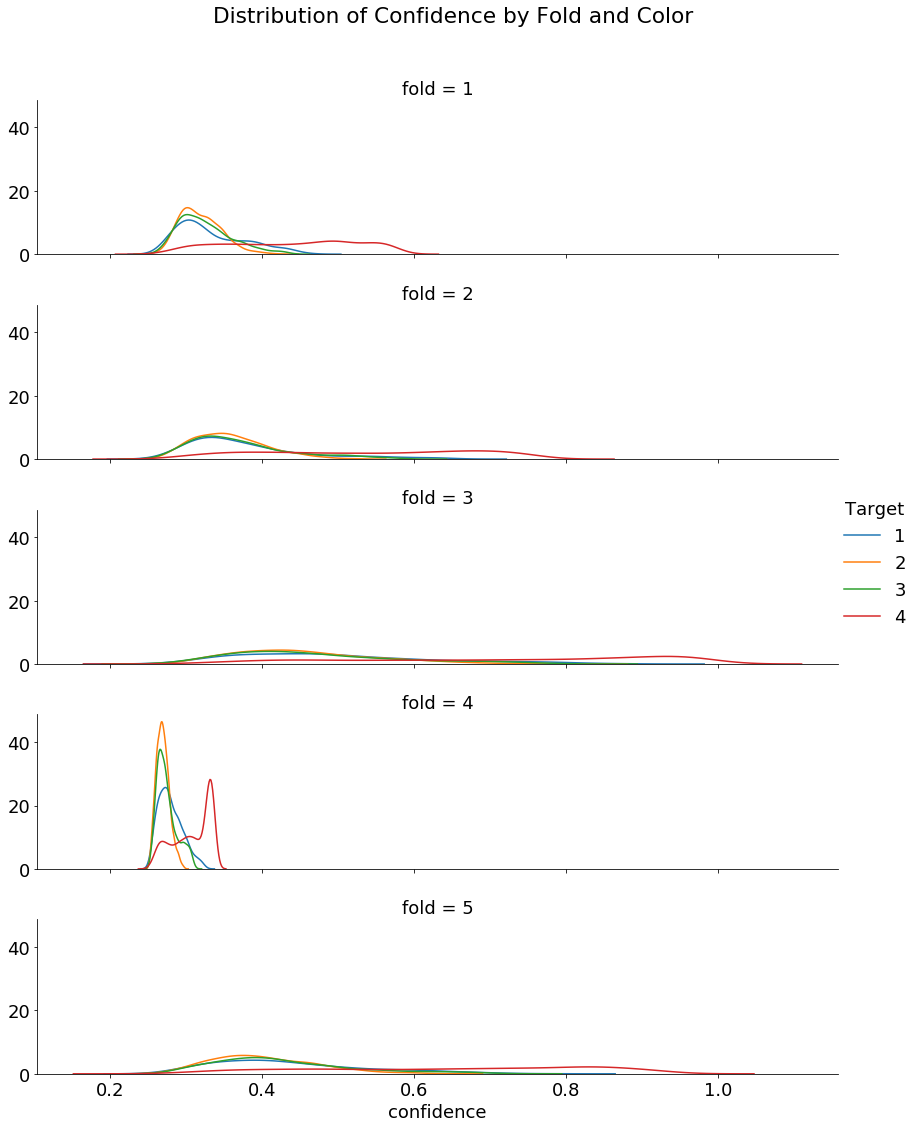

In [34]:
plt.rcParams['font.size'] = 18
g = sns.FacetGrid(predictions, row = 'fold', hue = 'Target', height = 3, aspect = 4)
g.map(sns.kdeplot, 'confidence');
g.add_legend();
plt.suptitle('Distribution of Confidence by Fold and Color', y = 1.05);

Our model is not very confident on any fold for any of the predictions. Overall, the class 4 seems to have the highest confidence, which makes sense because there are the most examples of this class in the data.

In [35]:
predictions.head()

,1,2,3,4,idhogar,fold,Target,confidence
0,0.143692,0.167076,0.187407,0.501826,000a08204,1,4,0.501826
1,0.294418,0.238965,0.266639,0.199979,000bce7c4,1,1,0.294418
2,0.133393,0.156649,0.164220,0.545738,001845fb0,1,4,0.545738
3,0.144609,0.241623,0.321776,0.291992,003514e22,1,3,0.321776
4,0.375222,0.300665,0.167087,0.157026,003b51a87,1,1,0.375222


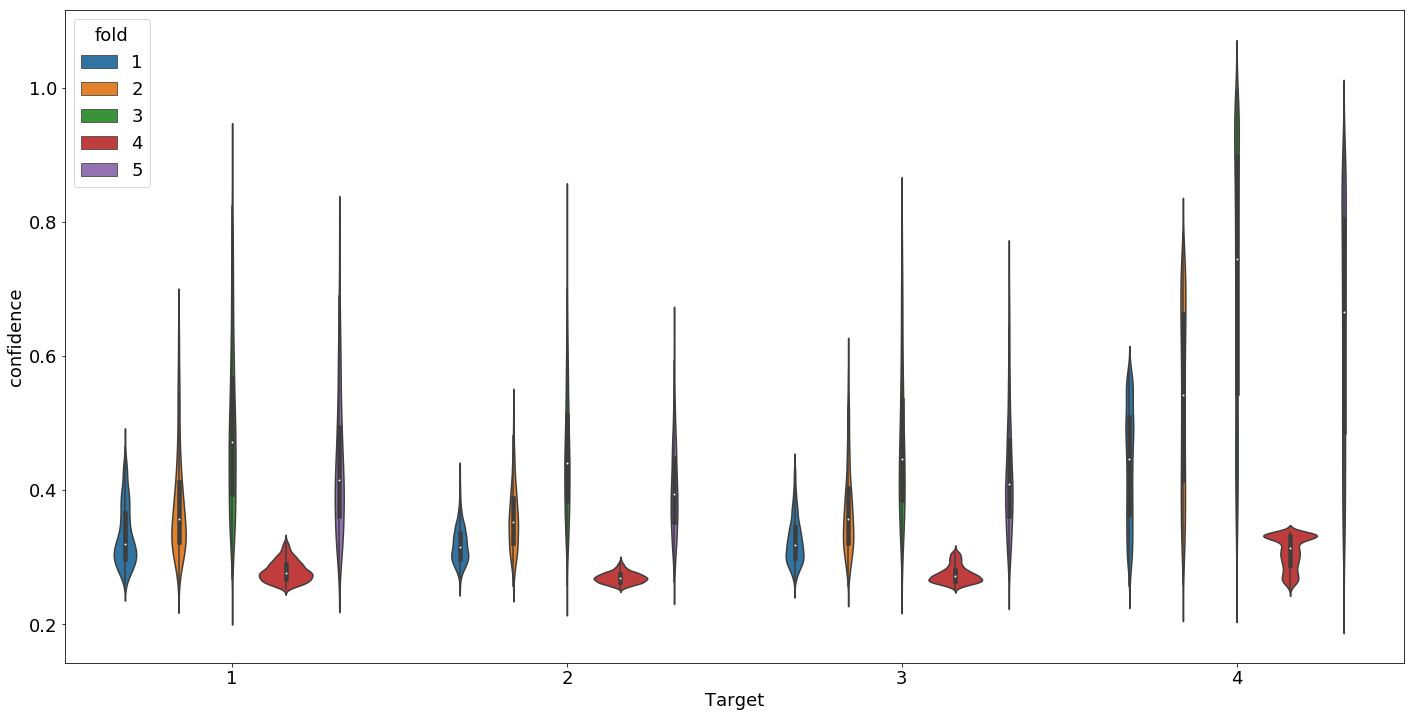

In [36]:
plt.figure(figsize = (24, 12))
sns.violinplot(x = 'Target', y = 'confidence', hue = 'fold', data = predictions);

Again, we see that class 4 has the highest confidence. There is significant difference in confidence levels across folds indications the predictions are not stable and depend heavily on the training data. Therefore, these predictions have high bias. We can potentially fix this by increasing the number of cross validation folds or by changing the sampling of the data (risky).

The next line models and returns the actual submissions for uploading. We'll also create a dataframe to keep track of the modeling results.

In [37]:
%%capture --no-display
submission, feature_importances, valid_scores = model_gbm(train, train_labels, test, test_ids, 5)

results = pd.DataFrame({'version': ['default_5fold'], 
                        'F1-mean': [valid_scores.mean()], 
                        'F1-std': [valid_scores.std()]})

'Fold 1, Validation Score: 0.42881, Estimators Trained: 13'

'Fold 2, Validation Score: 0.44654, Estimators Trained: 311'

'Fold 3, Validation Score: 0.43615, Estimators Trained: 250'

'Fold 4, Validation Score: 0.40483, Estimators Trained: 219'

'Fold 5, Validation Score: 0.38743, Estimators Trained: 79'

'5 cross validation score: 0.42075 with std: 0.02159.'

I'm not running the GBM with a random seed so the same set of features can produce different cross validation results. A random seed would ensure consistent results, but may have a singificant effect on the predictions. I don't want to get caught up trying to find the "right" random seed so I'm letting the predictions wander for now!

## Feature Importances

The utility function below plots feature importances and can show us how many features are needed for a certain cumulative level of importance. 

In [38]:
def plot_feature_importances(df, n = 15, return_features = False, threshold = None):
    """Plots n most important features. Also plots the cumulative importance if
    threshold is specified and prints the number of features needed to reach threshold cumulative importance.
    Intended for use with any tree-based feature importances. 
    
    Args:
        df (dataframe): Dataframe of feature importances. Columns must be "feature" and "importance".
    
        n (int): Number of most important features to plot. Default is 15.
    
        threshold (float): Threshold for cumulative importance plot. If not provided, no plot is made. Default is None.
        
    Returns:
        df (dataframe): Dataframe ordered by feature importances with a normalized column (sums to 1) 
                        and a cumulative importance column
    
    Note:
    
        * Normalization in this case means sums to 1. 
        * Cumulative importance is calculated by summing features from most to least important
        * A threshold of 0.9 will show the most important features needed to reach 90% of cumulative importance
    
    """
    
    # Sort features with most important at the head
    df = df.sort_values('importance', ascending = False).reset_index(drop = True)
    
    # Normalize the feature importances to add up to one and calculate cumulative importance
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])
    
    plt.rcParams['font.size'] = 12
    plt.style.use('fivethirtyeight')
    # Bar plot of n most important features
    df.loc[:n, :].plot.barh(y = 'importance_normalized', 
                            x = 'feature', color = 'blue', 
                            edgecolor = 'k', figsize = (12, 8),
                            legend = False, linewidth = 2)

    plt.xlabel('Normalized Importance', size = 18); plt.ylabel(''); 
    plt.title(f'Top {n} Most Important Features', size = 18)
    plt.gca().invert_yaxis()
    
    
    if threshold:
        # Cumulative importance plot
        plt.figure(figsize = (8, 6))
        plt.plot(list(range(len(df))), df['cumulative_importance'], 'b-')
        plt.xlabel('Number of Features', size = 16); plt.ylabel('Cumulative Importance', size = 16); 
        plt.title('Cumulative Feature Importance', size = 18);
        
        # Number of features needed for threshold cumulative importance
        # This is the index (will need to add 1 for the actual number)
        importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
        
        # Add vertical line to plot
        plt.vlines(importance_index + 1, ymin = 0, ymax = 1.05, linestyles = '--', colors = 'red')
        plt.show();
        
        print('{} features required for {:.0f}% of cumulative importance.'.format(importance_index + 1, 
                                                                                  100 * threshold))
    if return_features:
        return df

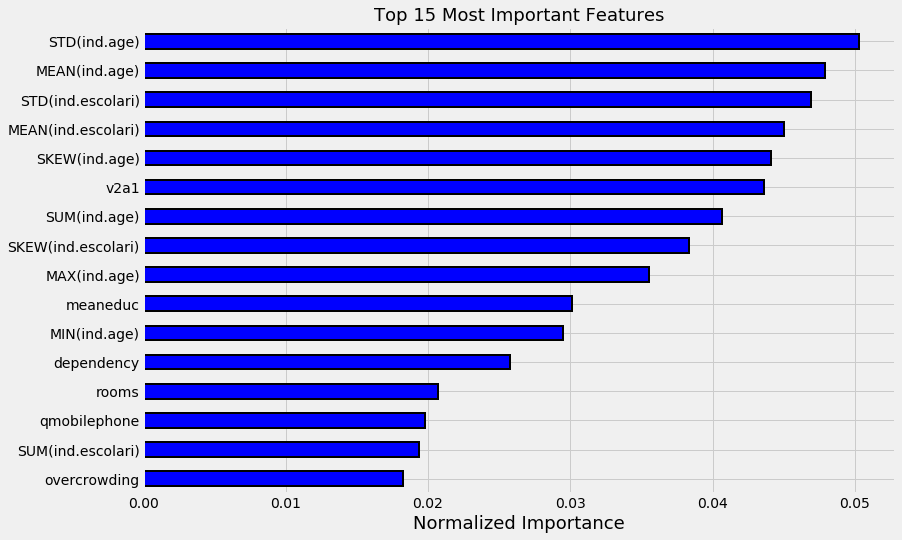

In [39]:
plot_feature_importances(feature_importances)

In [40]:
submission.to_csv('ft_baseline.csv', index = False)

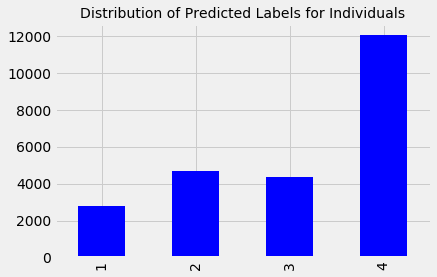

In [41]:
submission['Target'].value_counts().sort_index().plot.bar(color = 'blue');
plt.title('Distribution of Predicted Labels for Individuals', size = 14);

These shows the predictions on an individual, not household level (we set all individuals to 4 if they did not have a head of household). The distribution is close to what we observe in the training labels, which are provided on the household level.

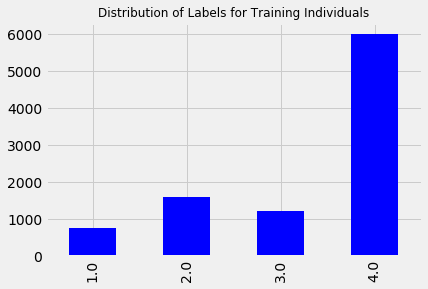

In [42]:
data[data['Target'].notnull()]['Target'].value_counts().sort_index().plot.bar(color = 'blue');
plt.title('Distribution of Labels for Training Individuals', size = 12);

# Custom Primitive

To expand the capabilities of featuretools, we can write our own primitives to be applied to the data. We'll write a simple function that finds the range of a numeric column. 

In [43]:
from featuretools.primitives import make_agg_primitive

# Custom primitive
def range_calc(numeric):
    return np.max(numeric) - np.min(numeric)

range_ = make_agg_primitive(function = range_calc,
                            input_types = [ft.variable_types.Numeric], 
                            return_type = ft.variable_types.Numeric)

We can also make a custom primitive that calculates the correlation coefficient between two columns.

In [44]:
def p_corr_calc(numeric1, numeric2):
    return np.corrcoef(numeric1, numeric2)[0, 1]

pcorr_ = make_agg_primitive(function = p_corr_calc,
                            input_types = [ft.variable_types.Numeric, ft.variable_types.Numeric], 
                            return_type = ft.variable_types.Numeric)

In [45]:
from scipy.stats import spearmanr

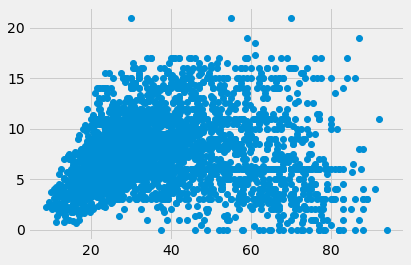

In [46]:
plt.plot(train['MEAN(ind.age)'], train['MEAN(ind.escolari)'], 'o');

In [47]:
np.corrcoef(train['MEAN(ind.age)'], train['MEAN(ind.escolari)'])[0, 1]

0.08516385085012615

In [48]:
spearmanr(train['MEAN(ind.age)'], train['MEAN(ind.escolari)'])[0]

0.1601591815347407

In [49]:
def s_corr_calc(numeric1, numeric2):
    return spearmanr(numeric1, numeric2)[0]

scorr_ = make_agg_primitive(function = s_corr_calc, 
                           input_types = [ft.variable_types.Numeric, ft.variable_types.Numeric], 
                           return_type = ft.variable_types.Numeric)

# More Featuretools

Why stop with 150 features? Let's add in a few more primitives and start creating more. To prevent featuretools from building the exact same features we already have, we can add `drop_exact` and pass in the feature names. 

In [50]:
feature_matrix_add, feature_names_add = ft.dfs(entityset=es, target_entity = 'household', 
                                              agg_primitives = ['min', 'max', 'mean', 'percent_true', 'all', 'any',
                                                             'sum', 'skew', 'std', range_],
                                          trans_primitives = [], drop_exact = list(all_features),
                                          max_depth = 2, 
                                          verbose = 1, n_jobs = 1,
                                          chunk_size = 100)

Built 76 features
Elapsed: 00:17 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 104/104 chunks


In [51]:
feature_matrix = pd.concat([feature_matrix, feature_matrix_add], axis = 1)
feature_matrix.shape

(10340, 217)

# Post Processing Function

There are a number of steps after generating the feature matrix so let's put all of these in a function. We'll also start removing columns with more than a certain percentage of missing values.

In [52]:
def post_process(feature_matrix, all_features, missing_threshold = 0.95, correlation_threshold = 0.99):
    
    feature_matrix = feature_matrix.iloc[:, ~feature_matrix.columns.duplicated()]
    feature_matrix = feature_matrix.replace({np.inf: np.nan, -np.inf:np.nan}).reset_index()
    
    # Remove the ids and labels
    ids = list(feature_matrix.pop('idhogar'))
    labels = list(feature_matrix.pop('Target'))
    
    # Remove columns derived from the Target
    drop_cols = []
    for col in feature_matrix:
        if col == 'Target':
            pass
        else:
            if 'Target' in col:
                drop_cols.append(col)
                
    feature_matrix = feature_matrix[[x for x in feature_matrix if x not in drop_cols]] 
    
    # One hot encoding (if necessary)
    feature_matrix = pd.get_dummies(feature_matrix)
    n_features_start = feature_matrix.shape[1]
    print('Original shape: ', feature_matrix.shape)
    
    # Find missing and percentage
    missing = pd.DataFrame(feature_matrix.isnull().sum())
    missing['fraction'] = missing[0] / feature_matrix.shape[0]
    missing.sort_values('fraction', ascending = False, inplace = True)

    # Missing above threshold
    missing_cols = list(missing[missing['fraction'] > missing_threshold].index)
    n_missing_cols = len(missing_cols)

    # Remove missing columns
    feature_matrix = feature_matrix[[x for x in feature_matrix if x not in missing_cols]]
    print('{} missing columns with threshold: {}.'.format(n_missing_cols, missing_threshold))
    
    # Zero variance
    unique_counts = pd.DataFrame(feature_matrix.nunique()).sort_values(0, ascending = True)
    zero_variance_cols = list(unique_counts[unique_counts[0] == 1].index)
    n_zero_variance_cols = len(zero_variance_cols)

    # Remove zero variance columns
    feature_matrix = feature_matrix[[x for x in feature_matrix if x not in zero_variance_cols]]
    print('{} zero variance columns.'.format(n_zero_variance_cols))
    
    # Correlations
    corr_matrix = feature_matrix.corr()

    # Extract the upper triangle of the correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k = 1).astype(np.bool))

    # Select the features with correlations above the threshold
    # Need to use the absolute value
    to_drop = [column for column in upper.columns if any(upper[column].abs() > correlation_threshold)]

    n_collinear = len(to_drop)
    
    feature_matrix = feature_matrix[[x for x in feature_matrix if x not in to_drop]]
    print('{} collinear columns removed with correlation above {}.'.format(n_collinear,  correlation_threshold))
    
    total_removed = n_missing_cols + n_zero_variance_cols + n_collinear
    
    print('Total columns removed: ', total_removed)
    print('Shape after feature selection: {}.'.format(feature_matrix.shape))
    
    # Extract the ids and labels
    feature_matrix['idhogar'] = ids
    feature_matrix['Target'] = labels
    
    # Extract out training and testing data
    train = feature_matrix[feature_matrix['Target'].notnull()]
    test = feature_matrix[feature_matrix['Target'].isnull()]
    
    # Subset to houses with a head of household
    train = train[train['idhogar'].isin(list(train_valid['idhogar']))]
    test = test[test['idhogar'].isin(list(test_valid['idhogar']))]
    
    # Training labels and testing household ids
    train_labels = np.array(train.pop('Target')).reshape((-1,))
    test_ids = list(test.pop('idhogar'))
    
    # Align the dataframes to ensure they have the same columns
    train, test = train.align(test, join = 'inner', axis = 1)
    
    all_features = list(set(list(all_features) + list(train.columns)))
    
    assert (len(train_labels) == train.shape[0]), "Labels must be same length as number of training observations"
    assert(len(test_ids) == test.shape[0]), "Must be equal number of test ids as testing observations"
    
    return train, train_labels, test, test_ids, all_features

In [53]:
train, train_labels, test, test_ids, all_features = post_process(feature_matrix, all_features)

Original shape:  (10340, 215)
0 missing columns with threshold: 0.95.
8 zero variance columns.
13 collinear columns removed with correlation above 0.99.
Total columns removed:  21
Shape after feature selection: (10340, 194).


In [54]:
%%capture --no-display
submission, feature_importances, valid_scores = model_gbm(train, train_labels, test, test_ids, 5)
results = results.append(pd.DataFrame({'version': ['additional_5fold'], 'F1-mean': [valid_scores.mean()], 'F1-std': [valid_scores.std()]}))

'Fold 1, Validation Score: 0.4324, Estimators Trained: 23'

'Fold 2, Validation Score: 0.4023, Estimators Trained: 164'

'Fold 3, Validation Score: 0.41949, Estimators Trained: 58'

'Fold 4, Validation Score: 0.42029, Estimators Trained: 106'

'Fold 5, Validation Score: 0.40949, Estimators Trained: 191'

'5 cross validation score: 0.4168 with std: 0.01026.'

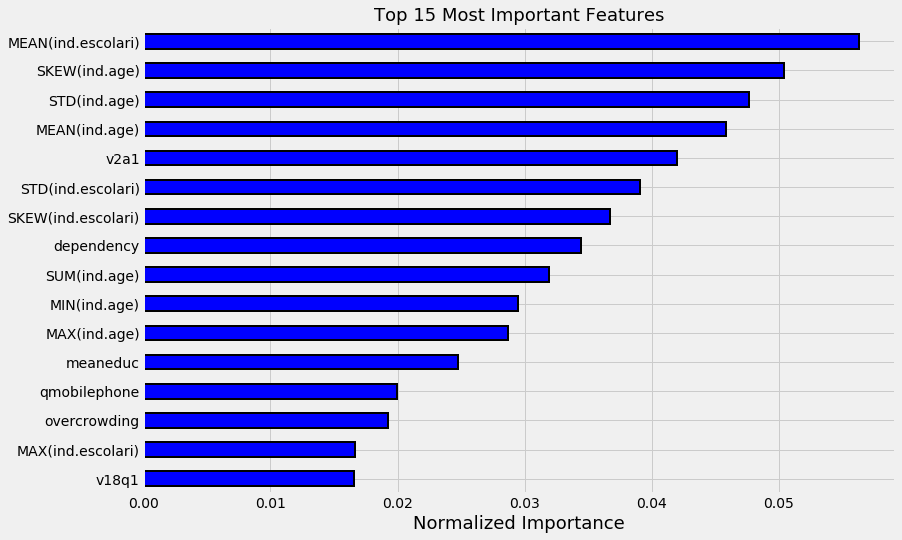

In [55]:
plot_feature_importances(feature_importances)

In [56]:
submission.to_csv('more_featuretools.csv', index = False)

In [57]:
feature_matrix_add, feature_names_add = ft.dfs(entityset=es, target_entity = 'household', 
                                       agg_primitives = ['min', 'max', 'mean', 'percent_true', 'all', 'any',
                                                         'sum', 'skew', 'std', range_, pcorr_, scorr_],
                                       trans_primitives = [], drop_exact = list(all_features),
                                       max_depth = 2, max_features = 1000,
                                       verbose = 1, n_jobs = -1, 
                                       chunk_size = 100)

feature_matrix = pd.concat([feature_matrix, feature_matrix_add], axis = 1)
feature_matrix.shape

Built 34 features
EntitySet scattered to workers in 1.347 seconds
Elapsed: 00:09 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 104/104 chunks


Future exception was never retrieved
future: <Future finished exception=CommClosedError('in <closed TCP>: Stream is closed',)>
Traceback (most recent call last):
  File "/home/ubuntu/.local/lib/python3.6/site-packages/distributed/comm/tcp.py", line 180, in read
    n_frames = yield stream.read_bytes(8)
  File "/home/ubuntu/.local/lib/python3.6/site-packages/tornado/gen.py", line 1133, in run
    value = future.result()
tornado.iostream.StreamClosedError: Stream is closed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/ubuntu/.local/lib/python3.6/site-packages/tornado/gen.py", line 1141, in run
    yielded = self.gen.throw(*exc_info)
  File "/home/ubuntu/.local/lib/python3.6/site-packages/distributed/comm/tcp.py", line 201, in read
    convert_stream_closed_error(self, e)
  File "/home/ubuntu/.local/lib/python3.6/site-packages/distributed/comm/tcp.py", line 129, in convert_stream_closed_error
    raise CommClosedErro

(10340, 251)

In [58]:
%%capture --no-display
train, train_labels, test, test_ids, all_features = post_process(feature_matrix, all_features)
submission, feature_importances, valid_scores = model_gbm(train, train_labels, test, test_ids, 5)
results = results.append(pd.DataFrame({'version': ['additional_5fold'], 'F1-mean': [valid_scores.mean()], 'F1-std': [valid_scores.std()]}))

'Fold 1, Validation Score: 0.45734, Estimators Trained: 39'

'Fold 2, Validation Score: 0.38801, Estimators Trained: 64'

'Fold 3, Validation Score: 0.4376, Estimators Trained: 32'

'Fold 4, Validation Score: 0.4222, Estimators Trained: 95'

'Fold 5, Validation Score: 0.41299, Estimators Trained: 2'

'5 cross validation score: 0.42363 with std: 0.0233.'

# Add in Divide Primitive

Next we'll add a `divide` transform primitive into the deep feature synthesis call. At first we'll limit the features to 1000. 

In [59]:
feature_matrix_add, feature_names_add = ft.dfs(entityset=es, target_entity = 'household', 
                                       agg_primitives = ['min', 'max', 'mean', 'percent_true', 'all', 'any',
                                                         'sum', 'skew', 'std', range_, pcorr_],
                                       trans_primitives = ['divide'], drop_exact = list(all_features),
                                       max_depth = 2, max_features = 1000,
                                       verbose = 1, n_jobs = -1,
                                       chunk_size = 1000)

feature_matrix = pd.concat([feature_matrix, feature_matrix_add], axis = 1)
feature_matrix.shape

Exception ignored in: <generator object add_client at 0x7fd6b7cefca8>
RuntimeError: generator ignored GeneratorExit
Future exception was never retrieved
future: <Future finished exception=CommClosedError('in <closed TCP>: Stream is closed',)>
Traceback (most recent call last):
  File "/home/ubuntu/.local/lib/python3.6/site-packages/distributed/comm/tcp.py", line 180, in read
    n_frames = yield stream.read_bytes(8)
  File "/home/ubuntu/.local/lib/python3.6/site-packages/tornado/gen.py", line 1133, in run
    value = future.result()
tornado.iostream.StreamClosedError: Stream is closed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/ubuntu/.local/lib/python3.6/site-packages/tornado/gen.py", line 1141, in run
    yielded = self.gen.throw(*exc_info)
  File "/home/ubuntu/.local/lib/python3.6/site-packages/distributed/comm/tcp.py", line 201, in read
    convert_stream_closed_error(self, e)
  File "/home/ubuntu/.local/lib

Built 1000 features
EntitySet scattered to workers in 1.387 seconds
Elapsed: 00:42 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 11/11 chunks

tornado.application - ERROR - Exception in Future <Future cancelled> after timeout
Traceback (most recent call last):
  File "/home/ubuntu/.local/lib/python3.6/site-packages/tornado/gen.py", line 970, in error_callback
    future.result()
concurrent.futures._base.CancelledError


(10340, 1251)

In [60]:
%%capture --no-display
train, train_labels, test, test_ids, all_features = post_process(feature_matrix, all_features)
submission, feature_importances, valid_scores = model_gbm(train, train_labels, test, test_ids, 5)
results = results.append(pd.DataFrame({'version': ['divide1000_5fold'], 'F1-mean': [valid_scores.mean()], 'F1-std': [valid_scores.std()]}))
submission.to_csv('divide1000_featuretools.csv', index = False)

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:40146 remote=tcp://127.0.0.1:41759>


'Fold 1, Validation Score: 0.42822, Estimators Trained: 61'

'Fold 2, Validation Score: 0.41563, Estimators Trained: 68'

'Fold 3, Validation Score: 0.4258, Estimators Trained: 69'

'Fold 4, Validation Score: 0.45821, Estimators Trained: 119'

'Fold 5, Validation Score: 0.43201, Estimators Trained: 156'

'5 cross validation score: 0.43197 with std: 0.0142.'

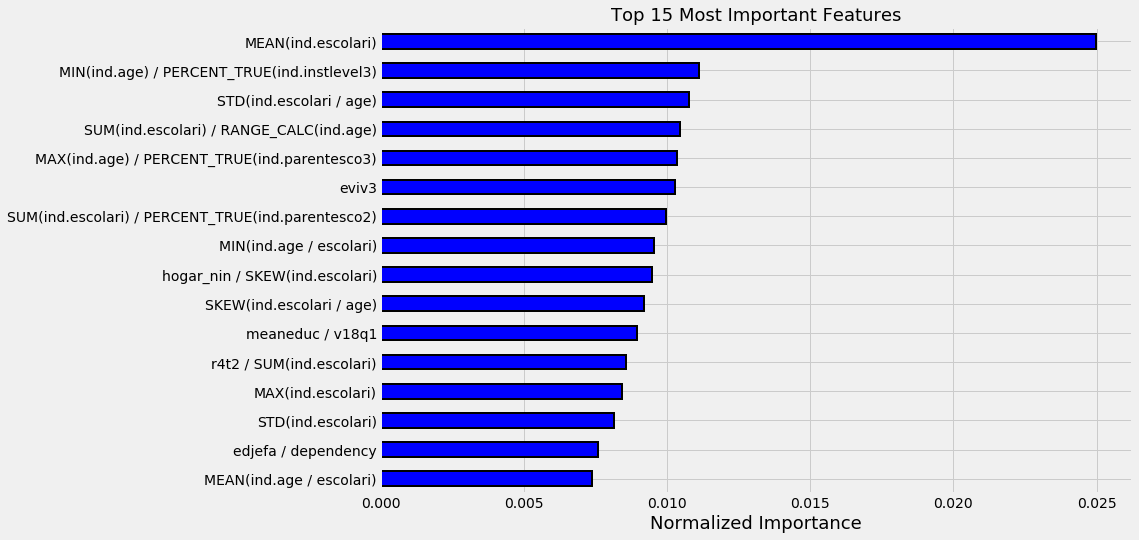

In [61]:
plot_feature_importances(feature_importances)

## Increase to 1500 features

1000 is clearly not enough! Most of these features are highly correlated, but we can still find useful features as evidenced by the feature importances.

In [62]:
feature_matrix_add, feature_names_add = ft.dfs(entityset=es, target_entity = 'household', 
                                       agg_primitives = ['min', 'max', 'mean', 'percent_true', 'all', 'any',
                                                         'sum', 'skew', 'std', range_, pcorr_],
                                       trans_primitives = ['divide'], drop_exact = list(all_features),
                                       max_depth = 2, max_features = 1500,
                                       verbose = 1, n_jobs = -1, 
                                       chunk_size = 100)

feature_matrix = pd.concat([feature_matrix, feature_matrix_add], axis = 1)
feature_matrix.shape

Exception ignored in: <generator object add_client at 0x7fd6b7db4bf8>
RuntimeError: generator ignored GeneratorExit
Future exception was never retrieved
future: <Future finished exception=CommClosedError('in <closed TCP>: Stream is closed',)>
Traceback (most recent call last):
  File "/home/ubuntu/.local/lib/python3.6/site-packages/distributed/comm/tcp.py", line 180, in read
    n_frames = yield stream.read_bytes(8)
  File "/home/ubuntu/.local/lib/python3.6/site-packages/tornado/gen.py", line 1133, in run
    value = future.result()
tornado.iostream.StreamClosedError: Stream is closed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/ubuntu/.local/lib/python3.6/site-packages/tornado/gen.py", line 1141, in run
    yielded = self.gen.throw(*exc_info)
  File "/home/ubuntu/.local/lib/python3.6/site-packages/distributed/comm/tcp.py", line 201, in read
    convert_stream_closed_error(self, e)
  File "/home/ubuntu/.local/lib

Built 1500 features
EntitySet scattered to workers in 1.411 seconds
Elapsed: 01:01 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 104/104 chunks


tornado.application - ERROR - Exception in Future <Future cancelled> after timeout
Traceback (most recent call last):
  File "/home/ubuntu/.local/lib/python3.6/site-packages/tornado/gen.py", line 970, in error_callback
    future.result()
concurrent.futures._base.CancelledError
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:50850 remote=tcp://127.0.0.1:33893>


(10340, 2751)

In [63]:
%%capture --no-display
train, train_labels, test, test_ids, all_features = post_process(feature_matrix, all_features)
submission, feature_importances, valid_scores = model_gbm(train, train_labels, test, test_ids, 5)
results = results.append(pd.DataFrame({'version': ['divide1500_5fold'], 'F1-mean': [valid_scores.mean()], 'F1-std': [valid_scores.std()]}))
submission.to_csv('divide1500_featuretools.csv', index = False)

'Fold 1, Validation Score: 0.38873, Estimators Trained: 176'

'Fold 2, Validation Score: 0.40939, Estimators Trained: 4'

'Fold 3, Validation Score: 0.46446, Estimators Trained: 29'

'Fold 4, Validation Score: 0.44581, Estimators Trained: 224'

'Fold 5, Validation Score: 0.42949, Estimators Trained: 235'

'5 cross validation score: 0.42757 with std: 0.02659.'

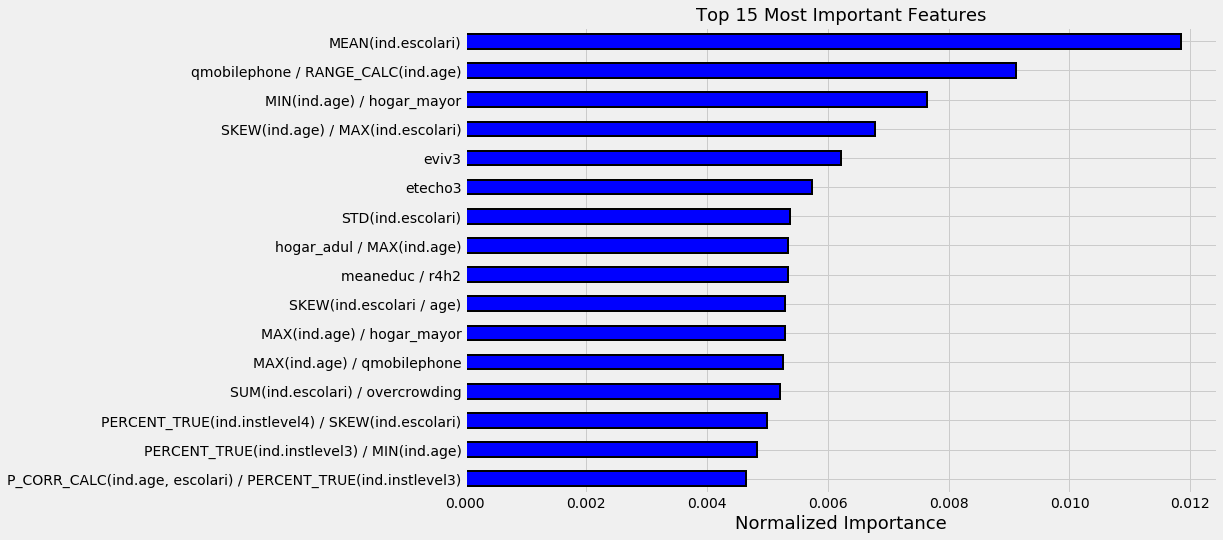

In [64]:
plot_feature_importances(feature_importances)

## Go to 2000

This is getting ridiculous.



In [65]:
feature_matrix_add, feature_names_add = ft.dfs(entityset=es, target_entity = 'household', 
                                       agg_primitives = ['min', 'max', 'mean', 'percent_true', 'all', 'any',
                                                         'sum', 'skew', 'std', range_, pcorr_],
                                       trans_primitives = ['divide'], drop_exact = list(all_features),
                                       max_depth = 2, max_features = 2000,
                                       verbose = 1, n_jobs = -1, 
                                       chunk_size = 100)

feature_matrix = pd.concat([feature_matrix, feature_matrix_add], axis = 1)
feature_matrix.shape

Built 2000 features
EntitySet scattered to workers in 1.454 seconds
Elapsed: 01:13 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 104/104 chunks

tornado.application - ERROR - Exception in Future <Future cancelled> after timeout
Traceback (most recent call last):
  File "/home/ubuntu/.local/lib/python3.6/site-packages/tornado/gen.py", line 970, in error_callback
    future.result()
concurrent.futures._base.CancelledError


distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:51024 remote=tcp://127.0.0.1:32907>


(10340, 4751)

In [66]:
%%capture --no-display

train, train_labels, test, test_ids, all_features = post_process(feature_matrix, all_features)
submission, feature_importances, valid_scores = model_gbm(train, train_labels, test, test_ids, 5)
results = results.append(pd.DataFrame({'version': ['divide2000_5fold'], 'F1-mean': [valid_scores.mean()], 'F1-std': [valid_scores.std()]}))
submission.to_csv('divide2000_featuretools.csv', index = False)

'Fold 1, Validation Score: 0.42396, Estimators Trained: 7'

'Fold 2, Validation Score: 0.44766, Estimators Trained: 73'

'Fold 3, Validation Score: 0.39763, Estimators Trained: 48'

'Fold 4, Validation Score: 0.42343, Estimators Trained: 105'

'Fold 5, Validation Score: 0.42869, Estimators Trained: 242'

'5 cross validation score: 0.42427 with std: 0.01598.'

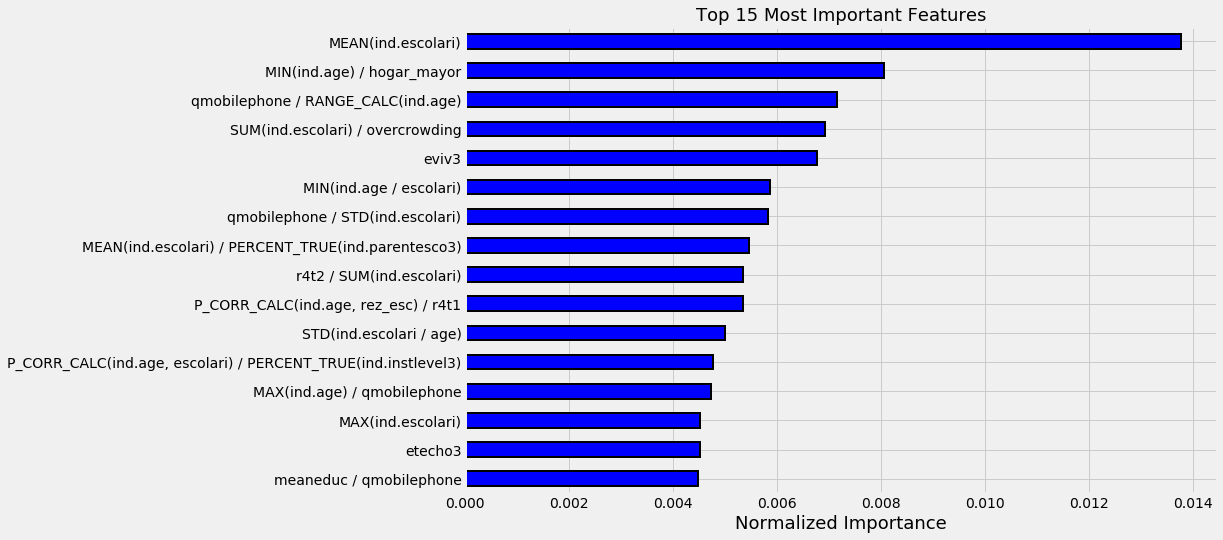

In [67]:
plot_feature_importances(feature_importances)

# Try Modeling with more folds

As a final model, we'll increase the number of folds to 10 and see if this results in more stable predictions across folds. It's concerning that there is so much variation between folds, but that is going to happen with a small, imbalanced testing set.

In [68]:
%%capture --no-display
submission, feature_importances, valid_scores = model_gbm(train, train_labels, test, test_ids, 10)
results = results.append(pd.DataFrame({'version': ['divide2000_10fold'], 'F1-mean': [valid_scores.mean()], 'F1-std': [valid_scores.std()]}))
submission.to_csv('divide2000_10fold_featuretools.csv', index = False)

'Fold 1, Validation Score: 0.44395, Estimators Trained: 190'

'Fold 2, Validation Score: 0.49796, Estimators Trained: 118'

'Fold 3, Validation Score: 0.45173, Estimators Trained: 61'

'Fold 4, Validation Score: 0.41212, Estimators Trained: 6'

'Fold 5, Validation Score: 0.37218, Estimators Trained: 7'

'Fold 6, Validation Score: 0.45604, Estimators Trained: 69'

'Fold 7, Validation Score: 0.40593, Estimators Trained: 327'

'Fold 8, Validation Score: 0.465, Estimators Trained: 73'

'Fold 9, Validation Score: 0.42149, Estimators Trained: 411'

'Fold 10, Validation Score: 0.40814, Estimators Trained: 15'

'10 cross validation score: 0.43345 with std: 0.03444.'

# Comparison of Models

At this point we might honestly ask if there is any benefit to increasing the number of features. Only one way to find out: through data! Let's look at the performance of models so far.

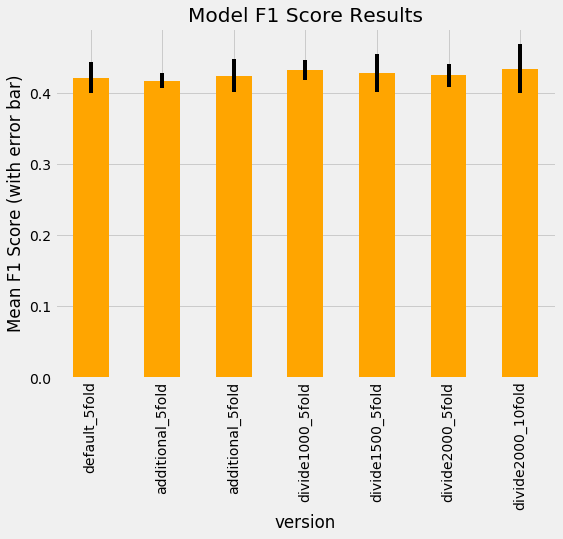

In [69]:
results.set_index('version', inplace = True)

results['F1-mean'].plot.bar(color = 'orange', figsize = (8, 6),
                                  yerr = list(results['F1-std']))
plt.title('Model F1 Score Results');
plt.ylabel('Mean F1 Score (with error bar)');

The cross validation accuracy continues to increase as we add features. I think we should be able to add more features as long as we continue to impose feature selection. The gradient boosting machine seems very good at cutting through the swath of features. Eventually we're probably going to be overfitting to the training data, but the we can address that through regularization and feature selection.

# Save Data

We can save the final selected featuretools feature matrix (created with a maximum of 2000 features). This will be used for Bayesian optimization of model hyperparameters. There still might be additional gains to increasing the number of features and/or using different custom primitives. My focus is now going to shift to modeling, but I encourage anyone to keep adjusting the featuretools implementation.

In [70]:
feature_matrix = feature_matrix.iloc[:, ~feature_matrix.columns.duplicated()].reset_index()

In [71]:
train_ids = list(feature_matrix[(feature_matrix['Target'].notnull()) & (feature_matrix['idhogar'].isin(list(train_valid['idhogar'])))]['idhogar'])

In [72]:
train['Target'] = train_labels
test['Target'] = np.nan
train['idhogar'] = train_ids
test['idhogar'] = test_ids
data = train.append(test)

results.to_csv('model_results.csv', index = True)
data.to_csv('ft_2000.csv', index = False)

In [73]:
data.shape

(10307, 2328)

# Conclusions

Featuretools certainly can make our job easier for this problem! Adding features continues to improve the validation score with mixed effects on the public leaderboard. The next step is to optimize the model for these features. __Featuretools should be a default part of your data science workflow.__ The tool is incredibly simple to use and delivers considerable value, creating features that we never would have imagined. I look forward to seeing what the community can come up with for this problem! 